In [2]:
# We first get our baseline DQN and then the improved DQN with model based exploration
# Then we show results for Policy Gradient Method - ENFORCE which acts as baseline for both DQN's 
# Finally we show results at the end for both Mountain Car and Lunar Lander for all three 
# methods namely DQN with model based exploration,DQN and Policy Gradient(ENFORCE)

# Importing Relevant Packages
import numpy as np
import random
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import gym
import time
#from gym import wrappers


# This DQN is used as a baseline and starter code for our improved DQN with model based exploration
class Agent:
    def __init__(self,env):
        pass

    def act(self, state):
        pass

    def update_model(self, state, action, reward, new_state, done):
        pass

class DQN_Agent(Agent):
    def __init__(self, env):
        self.env = env
        self.replay_memory = deque(maxlen=200000)

        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9995
        self.learning_rate = 0.05
        self.target_update_counter = 0
        self.C = 8 # interval for updating target network
        self.initial_random_steps = 0
        self.actions_count = 0
        self.clip_errors = True
        self.mini_batch_size = 16
        self.q_network = self.init_q_network()
        self.target_q_network = self.init_q_network()

    def on_episode_start(self):
        pass

    def on_episode_end(self):
        pass

    def get_observation_space(self):
        return self.env.observation_space

    def get_action_space(self):
        return self.env.action_space

    def init_q_network(self):
        model = Sequential()
        state_shape = self.get_observation_space().shape
        model.add(Dense(48, input_shape=state_shape, activation="relu"))
        model.add(Dense(self.get_action_space().n, activation='linear'))
        model.compile(loss="mean_squared_error", optimizer=Adam(lr=self.learning_rate))
        return model

    def act(self, state):
        self.actions_count += 1
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        if np.random.random() < self.epsilon or self.actions_count < self.initial_random_steps:
            return self.get_action_space().sample()
        return np.argmax(self.q_network.predict(state)[0])

    def update_model(self, state, action, reward, new_state, done):
        self.replay_memory.append([state, action, reward, new_state, done])
        self.fit_q_network()
        self.update_target_q_network()

    def sample_replays(self,batch_size):
        return random.sample(self.replay_memory, batch_size)

    def fit_q_network(self):
        #sample replay and do SGD
        batch_size = self.mini_batch_size
        if len(self.replay_memory) < batch_size:
            return

        samples = self.sample_replays(batch_size)
        sampled_states = []
        sampled_targets = []
        for sample in samples:
            state, action, reward, new_state, done = sample
            target = self.target_q_network.predict(state)
            predicted = self.q_network.predict(state)
            if done:
                target[0][action] = reward
            else:
                #update target by Bellman equation
                target[0][action] = reward + self.gamma * max(self.target_q_network.predict(new_state)[0])

                if self.clip_errors:
                    #clip error to -1, +1
                    if (target[0][action] > predicted[0][action]):
                        target[0][action] = predicted[0][action] + 1
                    elif (target[0][action] > predicted[0][action]):
                        target[0][action] = predicted[0][action] - 1
            sampled_states.append(state)
            sampled_targets.append(target)

        batched_states = np.concatenate(sampled_states,axis=0)
        batched_targets = np.concatenate(sampled_targets,axis=0)
        self.q_network.fit(batched_states, batched_targets, epochs=1, verbose=0)

    def update_target_q_network(self):
        #update target q network every C steps
        self.target_update_counter += 1
        if (self.target_update_counter > self.C):
            self.target_update_counter = 0
            self.target_q_network.set_weights(self.q_network.get_weights())

In [3]:
# Class for model based guided exploration which takes the DQN class we created above as input

class DQN_Guided_Exploration(DQN_Agent):
    def __init__(self, env):
        self.env = env
        self.replay_memory = deque(maxlen=200000)

        #Hyper-Parameters for DQN with model based exploration for Mountain Car
        self.epsilon_min = 0.01 # epsilon Minimum
        self.epsilon_decay = 0.9995 # epsilon decay
        self.gamma = 0.99 # Reward discount
        self.learning_rate = 0.05 # Learning rate (Q-network) 
        self.dynamics_network_lr = 0.02 # Learning rate (Dynamics network)
        self.C = 8 # Target Q-network update interval 
        self.initial_random_steps = 10000 # Initial exploration only steps
        self.mini_batch_size = 16 # Minibatch size (Q-network)
        self.mbs_dynamics_network = 64 # Minibatch size (dynamics predictor network)
        self.explore_sample = 50 #Number of recent states to fit probability model
        

        '''#Hyper-Parameters for DQN with model based exploration for Lunar Lander
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9995
        self.learning_rate = 0.05
        self.target_update_counter = 0
        self.C = 8 # intervcal for updating target network
        self.initial_random_steps = 5000
        self.actions_count = 0
        self.clip_errors = True'''

        self.epsilon = 1.0
        self.target_update_counter = 0
        self.actions_count = 0
        self.clip_errors = True
        self.q_network = self.init_q_network()
        self.target_q_network = self.init_q_network()
        self.dynamics_model = self.init_dynamics_model()
        self.update_count = 0
        self.dynamics_model_converged = False

    def update_model(self, state, action, reward, new_state, done):

        self.replay_memory.append([state, action, reward, new_state, done])
        self.fit_q_network()
        self.update_target_q_network()
        self.update_count += 1

        if self.update_count % 25 == 0:
            self.fit_dynamics_model()
        if self.update_count % 500 == 0:
            self.eval_dynamics_model()

    def act(self, state):
        self.actions_count += 1
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        if np.random.random() < self.epsilon or self.actions_count < self.initial_random_steps:
            return self.explore(state)
        return np.argmax(self.q_network.predict(state)[0])

    def explore(self,state):
        if not self.dynamics_model_converged:
            return self.get_action_space().sample()
        #return self.get_action_space().sample()
        N = len(self.replay_memory)
        num_samples = self.explore_sample
        samples = []
        for i in range(N-num_samples,N):
            samples.append(self.replay_memory[i][0])

        least_p = np.inf
        best_a = -1
        for action in range(self.get_action_space().n):
            next_state = self.dynamics_model.predict(np.append(state, [[action]], axis=1))
            p = self.get_probability(next_state, samples)
            if p < least_p:
                best_a = action
                least_p = p
        return best_a

    def get_probability(self,state, samples):
        design = []
        for s in samples:
            design.append(s[0])
        design = np.stack(design).T
        cov = np.cov(design)
        mean = np.mean(design,axis = 1)
        p = stats.multivariate_normal.pdf(state[0],mean,cov)
        return p

    def init_dynamics_model(self):
        model = Sequential()
        state_shape = (self.get_observation_space().shape[0] + 1,)
        print(state_shape)
        model.add(Dense(24, input_shape=state_shape, activation="relu"))
        model.add(Dense(24, activation="relu"))
        model.add(Dense(self.get_observation_space().shape[0], activation='linear'))
        model.compile(loss="mean_squared_error", optimizer=Adam(lr=self.dynamics_network_lr))
        return model

    def fit_dynamics_model(self):
        batchsize = self.mbs_dynamics_network
        if len(self.replay_memory) < batchsize:
            return
        samples = self.sample_replays(batchsize)
        sampled_states = []
        sampled_targets = []
        for sample in samples:
            state, action, reward, new_state, done = sample
            input_state = np.append(state, [[action]], axis=1)
            target = new_state
            sampled_states.append(input_state)
            sampled_targets.append(target)

        batched_inputs = np.concatenate(sampled_states, axis=0)
        batched_targets = np.concatenate(sampled_targets, axis=0)
        self.dynamics_model.fit(batched_inputs, batched_targets, epochs=1, verbose=0)

    #debug use only
    def eval_dynamics_model(self):
        samples = self.sample_replays(32)
        sampled_states = []
        sampled_targets = []
        for sample in samples:
            state, action, reward, new_state, done = sample
            input_state = np.append(state, [[action]], axis=1)
            target = new_state
            sampled_states.append(input_state)
            sampled_targets.append(target)

        batched_inputs = np.concatenate(sampled_states, axis=0)
        batched_targets = np.concatenate(sampled_targets, axis=0)
        scores = self.dynamics_model.evaluate(batched_inputs,batched_targets,verbose=0)
        if scores < 0.005:
            self.dynamics_model_converged = True
            print('Dynamics model has converged!')
        print(self.dynamics_model.metrics_names, scores)

In [4]:
# We create functions for scatter plots and reward plots

def plot_state_scatter(agent,title1,title2,xlabel1,ylabel1,xlabel2,ylabel2,color, lim1 = [-0.1,0.1,-1.4,0.6],lim2=[-2.0,1.0,-2.0,2.0]):
    fig = plt.figure()

    a = []
    b = []
    sample_size = min(2000,len(agent.replay_memory))
    for sample in random.sample(agent.replay_memory, sample_size):
        a.append(sample[0][0][0])
        b.append(sample[0][0][1])

    sub1 = fig.add_subplot(2,2,1)
    sub1.grid(True,linewidth='0.4',color='white')
    sub1.set_xlabel(xlabel1)
    sub1.set_ylabel(ylabel1)
    sub1.set_ylim(bottom=lim1[0],top = lim1[1])
    sub1.yaxis.set_major_locator(ticker.MultipleLocator(0.02))
    sub1.set_xlim(left=lim1[2],right=lim1[3])
    sub1.xaxis.set_major_locator(ticker.MultipleLocator(0.25))
    sub1.set_facecolor('#e6f3ff')
    sub1.scatter(a,b,s=3,color = color)

    if len(sample[0][0]) <= 2:
        return
    c = []
    d = []
    for sample in random.sample(agent.replay_memory, sample_size):
        c.append(sample[0][0][2])
        d.append(sample[0][0][3])

    sub2 = fig.add_subplot(2,2,2)
    sub2.grid(True,linewidth='0.4',color='white')
    sub2.set_xlabel(xlabel2)
    sub2.set_ylabel(ylabel2)
    sub2.set_ylim(bottom=lim2[0],top = lim2[1])
    sub2.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    sub2.set_xlim(left=lim2[2],right=lim2[3])
    sub2.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
    sub2.set_facecolor('#e6f3ff')
    sub2.scatter(c,d,s=3,color = color)


def plot_rewards_and_length(rewards, min_reward,max_reward, lengths):

    rewards_df = pd.DataFrame(rewards)
    rewards_df.to_csv('/content/rewards.csv')

    fig = plt.figure()
    sub1 = fig.add_subplot(2,2,1)
    sub1.set_title('Reward')
    sub1.set_ylim(bottom=min_reward,top=max_reward)
    sub1.set_xlabel('episodes')
    sub1.set_ylabel('reward')
    sub1.plot(rewards)

    avg_reward = [0.] * len(rewards)
    cumulative_rewards = [0.] * len(rewards)
    cumulated_r = 0.
    for i in range(len(rewards)):
        cumulated_r += rewards[i]
        cumulative_rewards[i] = cumulated_r
    #interval = 10

    for i in range(len(rewards)):
        if i <= 0:
            avg_reward[i] = rewards[i]
        else:
            avg_reward[i] = (cumulative_rewards[i] - cumulative_rewards[0])/i
    sub3 = fig.add_subplot(2,2,2)
    sub3.set_ylim(bottom=min_reward,top=max_reward)
    sub3.set_title('average rewards')
    sub3.set_xlabel('episodes')
    sub3.plot(avg_reward)
    plt.show()

episode 0 steps: 200, total reward: -200.0,  elapsed time: 383s
episode 1 steps: 200, total reward: -200.0,  elapsed time: 797s
episode 2 steps: 200, total reward: -200.0,  elapsed time: 1212s
episode 3 steps: 200, total reward: -200.0,  elapsed time: 1625s
episode 4 steps: 200, total reward: -200.0,  elapsed time: 2049s
episode 5 steps: 200, total reward: -200.0,  elapsed time: 2465s
episode 6 steps: 200, total reward: -200.0,  elapsed time: 2885s
episode 7 steps: 200, total reward: -200.0,  elapsed time: 3306s
episode 8 steps: 200, total reward: -200.0,  elapsed time: 3724s
episode 9 steps: 200, total reward: -200.0,  elapsed time: 4148s
episode 10 steps: 200, total reward: -200.0,  elapsed time: 4580s
episode 11 steps: 200, total reward: -200.0,  elapsed time: 5016s
episode 12 steps: 200, total reward: -200.0,  elapsed time: 5446s
episode 13 steps: 200, total reward: -200.0,  elapsed time: 5877s
episode 14 steps: 200, total reward: -200.0,  elapsed time: 6296s
episode 15 steps: 200,

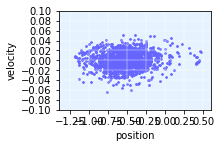

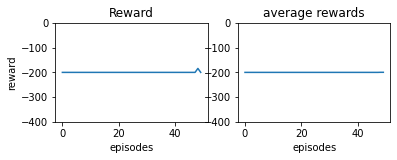

In [9]:
#CASE 1- Mountain Car and DQN

env_name = "MountainCar-v0"
max_episodes = 50 #We run for 50 epochs in our case
record_video_every = 100

def main():
    env = gym.make(env_name)
    env.seed(0)
    #env = wrappers.Monitor(env, 'replay', video_callable=lambda e: e%record_video_every == 0,force=True)

    state_shape = (1,env.observation_space.shape[0])
    agent = DQN_Agent(env=env)
    start_time = time.time()
    total_reward_list = []
    episode_length_list = []
    for episode in range(max_episodes):
        agent.on_episode_start()
        cur_state = env.reset().reshape(state_shape)
        steps = 0
        total_reward = 0
        done = False
        while not done:
            steps += 1
            action = agent.act(cur_state)
            new_state, reward, done, _ = env.step(action)
            new_state = new_state.reshape(state_shape)
            agent.update_model(cur_state, action, reward, new_state, done)
            cur_state = new_state
            total_reward += reward
            if done:
                break

        agent.on_episode_end()
        total_reward_list.append(total_reward)
        episode_length_list.append(steps)
        print('episode {} steps: {}, total reward: {},  elapsed time: {}s'.format(episode, steps, total_reward, int(time.time()-start_time)))

    plot_state_scatter(agent,title1='Mountain Car',title2='',xlabel1='position',ylabel1='velocity',xlabel2='x-velocity',ylabel2='y-velocity',color= '#6666ff')
    plot_rewards_and_length(total_reward_list, -400.,0., episode_length_list)

if __name__ == "__main__":
    main()

(3,)
episode 0 steps: 200, total reward: -200.0,  elapsed time: 372s
episode 1 steps: 200, total reward: -200.0,  elapsed time: 763s
Dynamics model has converged!
['loss'] 0.00102023605722934
episode 2 steps: 200, total reward: -200.0,  elapsed time: 1164s
episode 3 steps: 200, total reward: -200.0,  elapsed time: 1576s
Dynamics model has converged!
['loss'] 0.0008063983405008912
episode 4 steps: 200, total reward: -200.0,  elapsed time: 1988s
episode 5 steps: 200, total reward: -200.0,  elapsed time: 2398s
episode 6 steps: 200, total reward: -200.0,  elapsed time: 2808s
Dynamics model has converged!
['loss'] 0.00017372757429257035
episode 7 steps: 200, total reward: -200.0,  elapsed time: 3219s
episode 8 steps: 200, total reward: -200.0,  elapsed time: 3631s
Dynamics model has converged!
['loss'] 4.375408389023505e-05
episode 9 steps: 200, total reward: -200.0,  elapsed time: 4041s
episode 10 steps: 200, total reward: -200.0,  elapsed time: 4453s
episode 11 steps: 200, total reward: -

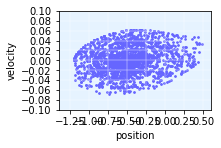

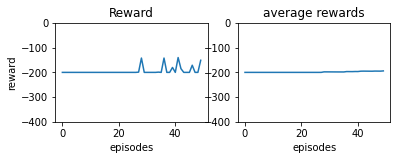

In [8]:
#CASE 2- Mountain Car and DQN with Model based Exploration

env_name = "MountainCar-v0"
max_episodes = 50 #We run for 50 epochs in our case
record_video_every = 100

def main():
    env = gym.make(env_name)
    env.seed(0)
    #env = wrappers.Monitor(env, 'replay', video_callable=lambda e: e%record_video_every == 0,force=True)

    state_shape = (1,env.observation_space.shape[0])
    agent = DQN_Guided_Exploration(env=env)
    start_time = time.time()
    total_reward_list = []
    episode_length_list = []
    for episode in range(max_episodes):
        agent.on_episode_start()
        cur_state = env.reset().reshape(state_shape)
        steps = 0
        total_reward = 0
        done = False
        while not done:
            steps += 1
            action = agent.act(cur_state)
            new_state, reward, done, _ = env.step(action)
            new_state = new_state.reshape(state_shape)
            agent.update_model(cur_state, action, reward, new_state, done)
            cur_state = new_state
            total_reward += reward
            if done:
                break

        agent.on_episode_end()
        total_reward_list.append(total_reward)
        episode_length_list.append(steps)
        print('episode {} steps: {}, total reward: {},  elapsed time: {}s'.format(episode, steps, total_reward, int(time.time()-start_time)))

    plot_state_scatter(agent,title1='Mountain Car',title2='',xlabel1='position',ylabel1='velocity',xlabel2='x-velocity',ylabel2='y-velocity',color= '#6666ff')
    plot_rewards_and_length(total_reward_list, -400.,0., episode_length_list)

if __name__ == "__main__":
    main()

Episode 1.0 and Total Rewards: -200.0
Episode 2.0 and Total Rewards: -200.0
Episode 3.0 and Total Rewards: -200.0
Episode 4.0 and Total Rewards: -200.0
Episode 5.0 and Total Rewards: -200.0
Episode 6.0 and Total Rewards: -200.0
Episode 7.0 and Total Rewards: -200.0
Episode 8.0 and Total Rewards: -200.0
Episode 9.0 and Total Rewards: -200.0
Episode 10.0 and Total Rewards: -200.0
Episode 11.0 and Total Rewards: -200.0
Episode 12.0 and Total Rewards: -200.0
Episode 13.0 and Total Rewards: -200.0
Episode 14.0 and Total Rewards: -200.0
Episode 15.0 and Total Rewards: -200.0
Episode 16.0 and Total Rewards: -200.0
Episode 17.0 and Total Rewards: -200.0
Episode 18.0 and Total Rewards: -200.0
Episode 19.0 and Total Rewards: -200.0
Episode 20.0 and Total Rewards: -200.0
Episode 21.0 and Total Rewards: -200.0
Episode 22.0 and Total Rewards: -200.0
Episode 23.0 and Total Rewards: -200.0
Episode 24.0 and Total Rewards: -200.0
Episode 25.0 and Total Rewards: -200.0
Episode 26.0 and Total Rewards: -2

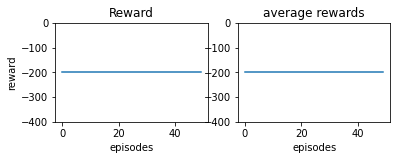

In [ ]:
#CASE 3- Mountain Car and Policy Gradient(REINFORCE)
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

env = gym.make('MountainCar-v0')
env.seed(0)
# print('observation space:', env.observation_space)
# print('action space:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self, s_size=2, h_size=1, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)


policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=0.02)

def reinforce(n_episodes=5000, max_t=1000, gamma=0.995, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    total_reward_list = []
    episode_length_list = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            total_reward_list.append(np.mean(scores_deque))
            episode_length_list.append(i_episode/100)
            print('Episode {} and Total Rewards: {}'.format(i_episode/100, np.mean(scores_deque)))

        if np.mean(scores_deque)>=195.0:
            total_reward_list.append(np.mean(scores_deque))
            episode_length_list.append(i_episode/100)
            print('Environment solved in {} episodes! and Total Rewards: {}'.format((i_episode/100)-1, np.mean(scores_deque)))
            break
        
    return episode_length_list,total_reward_list
    
episode_length_list,total_reward_list = reinforce()

plot_rewards_and_length(total_reward_list, -400.,0., episode_length_list)



In [1]:
# Now we run all cases for Lunar Lander environment
!pip3 install box2d-py
!pip3 install gym[Box_2D]
import gym
env = gym.make('LunarLander-v2')

     |████████████████████████████████| 450kB 7.9MB/s 


episode 0 steps: 99, total reward: -120.80487438916862,  elapsed time: 162s
episode 1 steps: 97, total reward: -120.31946214748066,  elapsed time: 350s
episode 2 steps: 94, total reward: -312.5058023743429,  elapsed time: 530s
episode 3 steps: 122, total reward: -452.2258853498155,  elapsed time: 766s
episode 4 steps: 97, total reward: -242.46911172836516,  elapsed time: 956s
episode 5 steps: 109, total reward: -151.48010732915867,  elapsed time: 1168s
episode 6 steps: 65, total reward: -86.03987340623209,  elapsed time: 1295s
episode 7 steps: 99, total reward: -143.5566628577394,  elapsed time: 1487s
episode 8 steps: 104, total reward: -210.8831688128921,  elapsed time: 1690s
episode 9 steps: 116, total reward: -164.2136185036553,  elapsed time: 1916s
episode 10 steps: 123, total reward: -203.67820404036934,  elapsed time: 2154s
episode 11 steps: 124, total reward: -348.37675063604615,  elapsed time: 2394s
episode 12 steps: 151, total reward: -120.13643966082489,  elapsed time: 2684s


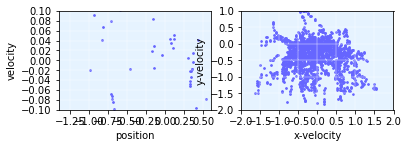

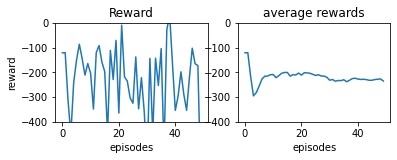

In [8]:
#CASE 4- Lunar Lander and DQN

env_name = "LunarLander-v2"
max_episodes = 50 #We run for 50 epochs in our case
record_video_every = 100

def main():
    env = gym.make(env_name)
    env.seed(0)
    #env = wrappers.Monitor(env, 'replay', video_callable=lambda e: e%record_video_every == 0,force=True)

    state_shape = (1,env.observation_space.shape[0])
    agent = DQN_Agent(env=env)
    start_time = time.time()
    total_reward_list = []
    episode_length_list = []
    for episode in range(max_episodes):
        agent.on_episode_start()
        cur_state = env.reset().reshape(state_shape)
        steps = 0
        total_reward = 0
        done = False
        while not done:
            steps += 1
            action = agent.act(cur_state)
            new_state, reward, done, _ = env.step(action)
            new_state = new_state.reshape(state_shape)
            agent.update_model(cur_state, action, reward, new_state, done)
            cur_state = new_state
            total_reward += reward
            if done:
                break

        agent.on_episode_end()
        total_reward_list.append(total_reward)
        episode_length_list.append(steps)
        print('episode {} steps: {}, total reward: {},  elapsed time: {}s'.format(episode, steps, total_reward, int(time.time()-start_time)))

    plot_state_scatter(agent,title1='Lunar Lander',title2='',xlabel1='position',ylabel1='velocity',xlabel2='x-velocity',ylabel2='y-velocity',color= '#6666ff')
    plot_rewards_and_length(total_reward_list, -400.,0., episode_length_list)

if __name__ == "__main__":
    main()

(9,)
episode 0 steps: 117, total reward: -144.98624442196436,  elapsed time: 220s
episode 1 steps: 73, total reward: -135.08105115004255,  elapsed time: 379s
episode 2 steps: 68, total reward: -36.32983155721342,  elapsed time: 524s
episode 3 steps: 128, total reward: -174.92741096430044,  elapsed time: 801s
episode 4 steps: 102, total reward: -270.7380492884978,  elapsed time: 1011s
['loss'] 0.03570457175374031
episode 5 steps: 121, total reward: 15.702353912552866,  elapsed time: 1256s
episode 6 steps: 114, total reward: -97.18996234796742,  elapsed time: 1489s
episode 7 steps: 88, total reward: -61.68671622464957,  elapsed time: 1668s
episode 8 steps: 90, total reward: -381.6007215571198,  elapsed time: 1851s
episode 9 steps: 79, total reward: -115.47784213075421,  elapsed time: 2013s
['loss'] 0.0248439721763134
episode 10 steps: 68, total reward: -80.82215181657898,  elapsed time: 2151s
episode 11 steps: 77, total reward: -97.68912875842688,  elapsed time: 2307s
episode 12 steps: 1

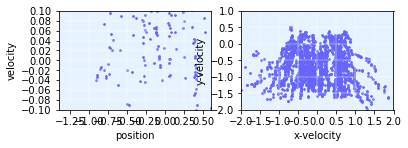

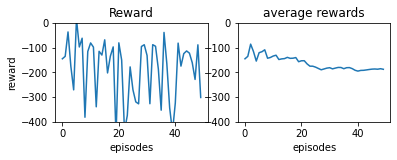

In [7]:
#CASE 5- Lunar Lander and DQN with Model based Exploration

env_name = "LunarLander-v2"
max_episodes = 50 #We run for 50 epochs in our case
record_video_every = 100

def main():
    env = gym.make(env_name)
    env.seed(0)
    #env = wrappers.Monitor(env, 'replay', video_callable=lambda e: e%record_video_every == 0,force=True)

    state_shape = (1,env.observation_space.shape[0])
    agent = DQN_Guided_Exploration(env=env)
    start_time = time.time()
    total_reward_list = []
    episode_length_list = []
    for episode in range(max_episodes):
        agent.on_episode_start()
        cur_state = env.reset().reshape(state_shape)
        steps = 0
        total_reward = 0
        done = False
        while not done:
            steps += 1
            action = agent.act(cur_state)
            new_state, reward, done, _ = env.step(action)
            new_state = new_state.reshape(state_shape)
            agent.update_model(cur_state, action, reward, new_state, done)
            cur_state = new_state
            total_reward += reward
            if done:
                break

        agent.on_episode_end()
        total_reward_list.append(total_reward)
        episode_length_list.append(steps)
        print('episode {} steps: {}, total reward: {},  elapsed time: {}s'.format(episode, steps, total_reward, int(time.time()-start_time)))

    plot_state_scatter(agent,title1='Lunar Lander',title2='',xlabel1='position',ylabel1='velocity',xlabel2='x-velocity',ylabel2='y-velocity',color= '#6666ff')
    plot_rewards_and_length(total_reward_list, -400.,0., episode_length_list)

if __name__ == "__main__":
    main()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 1.0 and Total Rewards: -262.08113394034973
Episode 2.0 and Total Rewards: -271.1235775590321
Episode 3.0 and Total Rewards: -192.09056849902242
Episode 4.0 and Total Rewards: -144.66829151481733
Episode 5.0 and Total Rewards: -136.51662297158936
Episode 6.0 and Total Rewards: -133.30534395315064
Episode 7.0 and Total Rewards: -137.71843653842623
Episode 8.0 and Total Rewards: -134.74970307729197
Episode 9.0 and Total Rewards: -136.8386590511779
Episode 10.0 and Total Rewards: -130.9307192988466
Episode 11.0 and Total Rewards: -127.92256213325838
Episode 12.0 and Total Rewards: -140.8049662985356
Episode 13.0 and Total Rewards: -140.77074087793432
Episode 14.0 and Total Rewards: -131.8546640478575
Episode 15.0 and Total Rewards: -132.9073490184423
Episode 16.0 and Total Rewards: -131.15589702035612
Episode 17.0 and Total Rewards: -133.10198189316438
Episode 18.0 and Total Rewards: -134.24015040494444
Episode 19.0 and Total Rewards: -140.59842196672264
Episode 20.0 and Total Rewa

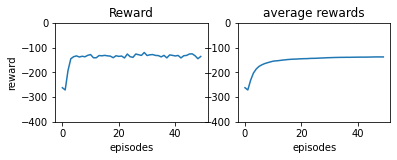

In [7]:
#CASE 6- Lunar Lander and Policy Gradient(REINFORCE)

import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical


env = gym.make('LunarLander-v2')
env.seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self, s_size=8, h_size=1, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)
    
    
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=0.02)

def reinforce(n_episodes=5000, max_t=1000, gamma=0.995, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    total_reward_list = []
    episode_length_list = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            total_reward_list.append(np.mean(scores_deque))
            episode_length_list.append(i_episode/100)
            print('Episode {} and Total Rewards: {}'.format(i_episode/100, np.mean(scores_deque)))

        if np.mean(scores_deque)>=195.0:
            total_reward_list.append(np.mean(scores_deque))
            episode_length_list.append(i_episode/100)
            print('Environment solved in {} episodes! and Total Rewards: {}'.format((i_episode/100)-1, np.mean(scores_deque)))
            break
        
    return episode_length_list,total_reward_list
    
episode_length_list,total_reward_list = reinforce()

plot_rewards_and_length(total_reward_list, -400.,0., episode_length_list)


In [33]:
# For Mountain Car Environment all three cases
%matplotlib inline
import seaborn as sns; sns.set()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27),'legend.fontsize': 18})



def get_merged_df(prefix,name):
    df1 = pd.read_csv(prefix + '.csv').iloc[:,1]
    df2=pd.DataFrame(df1)
    df2.columns = [name]
    return df2

#Please change the location of the file getting stored in your local here and keep the file name accordingly as well
#We get these files after renaming the rewards.csv file for each run and saving it at the location of the working directory
a_df = get_merged_df('/content/rewards_mc_dqn_ge','DQN (model-based exploration)')
b_df = get_merged_df('/content/rewards_mc_dqn','DQN')
c_df = get_merged_df('/content/rewards_mc_pg','Monte Carlo Policy Gradient (ENFORCE)')
df = pd.concat([a_df,b_df,c_df],axis=1)
df = df.expanding().mean()
df = df.iloc[:500,:]
df.tail(50)

,DQN (model-based exploration),DQN,Monte Carlo Policy Gradient (ENFORCE)
0,-200.000000,-200.000000,-200.0
1,-200.000000,-200.000000,-200.0
2,-200.000000,-200.000000,-200.0
3,-200.000000,-200.000000,-200.0
4,-200.000000,-200.000000,-200.0
5,-200.000000,-200.000000,-200.0
6,-200.000000,-200.000000,-200.0
7,-200.000000,-200.000000,-200.0
8,-200.000000,-200.000000,-200.0
9,-200.000000,-200.000000,-200.0


Text(0.5, 1.0, 'Average Rewards vs Episodes for all three cases for Mountain Car Environment')

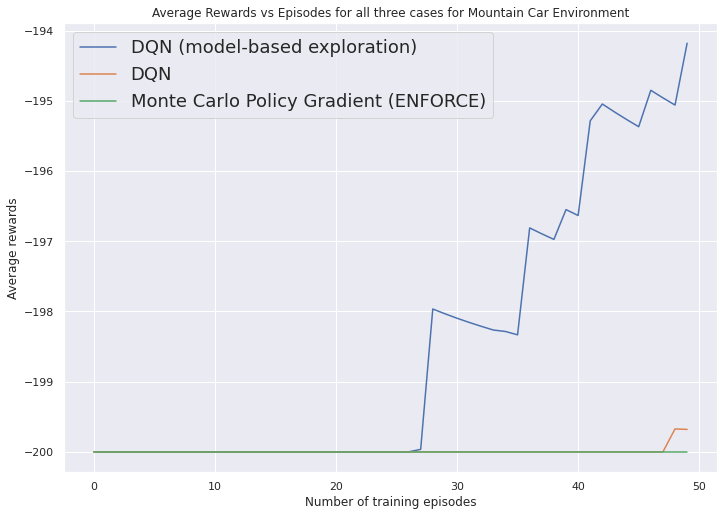

In [34]:
# For Mountain Car Environment all three cases

ax = sns.lineplot(data=df,color="red", dashes=False)
#ax.lines[0].set_linestyle("-")
#ax.lines[1].set_linestyle("-")
#ax.lines[2].set_linestyle("-")

ax.set_xlabel('Number of training episodes')
ax.set_ylabel('Average rewards')
ax.set_title('Average Rewards vs Episodes for all three cases for Mountain Car Environment')

In [2]:
# For Mountain Car Environment DQN and DQN Model Based Exploration cases only for 200 episodes run
%matplotlib inline
import seaborn as sns; sns.set()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27),'legend.fontsize': 18})



def get_merged_df(prefix,name):
    df1 = pd.read_csv(prefix + '.csv').iloc[:,1]
    df2=pd.DataFrame(df1)
    df2.columns = [name]
    return df2

#Please change the location of the file getting stored in your local here and keep the file name accordingly as well
#We get these files after renaming the rewards.csv file for each run and saving it at the location of the working directory
a_df = get_merged_df('/content/rewards_Mountain_Car_DQN_MB_200','DQN (model-based exploration)')
b_df = get_merged_df('/content/rewards_Mountain_Car_DQN_200','DQN')
df = pd.concat([a_df,b_df],axis=1)
df = df.expanding().mean()
df = df.iloc[:500,:]
df.tail(50)

,DQN (model-based exploration),DQN
150,-182.006623,-191.019868
151,-182.125000,-190.789474
152,-181.928105,-190.490196
153,-182.045455,-190.259740
154,-181.987097,-189.832258
155,-181.820513,-189.737179
156,-181.611465,-189.681529
157,-181.398734,-189.506329
158,-181.345912,-189.553459
159,-181.243750,-189.618750


Text(0.5, 1.0, 'Average Rewards vs Episodes for DQN and DQN Model Based Exploration cases for Mountain Car Environment and 200 Episode run')

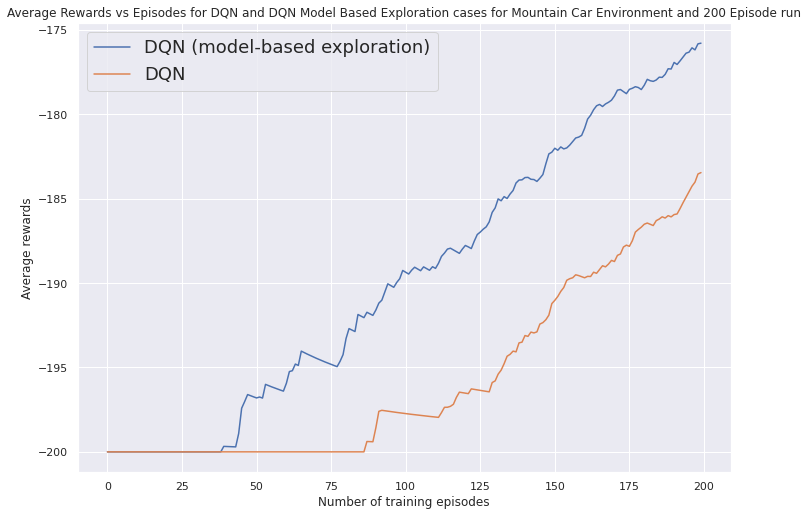

In [26]:
# For Mountain Car Environment DQN and DQN Model Based Exploration cases only for 200 episodes run

ax = sns.lineplot(data=df,color="red", dashes=False)

ax.set_xlabel('Number of training episodes')
ax.set_ylabel('Average rewards')
ax.set_title('Average Rewards vs Episodes for DQN and DQN Model Based Exploration cases for Mountain Car Environment and 200 Episode run')

In [3]:
# For Lunar Lander Environment all three cases

%matplotlib inline
import seaborn as sns; sns.set()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27),'legend.fontsize': 18})



def get_merged_df(prefix,name):
    df1 = pd.read_csv(prefix + '.csv').iloc[:,1]
    df2=pd.DataFrame(df1)
    df2.columns = [name]
    return df2

#Please change the location of the file getting stored in your local here and keep the file name accordingly as well
#We get these files after renaming the rewards.csv file for each run and saving it at the location of the working directory
a_df = get_merged_df('/content/rewards_ll_dqn_ge','DQN (model-based exploration)')
b_df = get_merged_df('/content/rewards_ll_dqn','DQN')
c_df = get_merged_df('/content/rewards_ll_pg','Monte Carlo Policy Gradient (ENFORCE)')
df = pd.concat([a_df,b_df,c_df],axis=1)
df = df.expanding().mean()
df = df.iloc[:500,:]
df.tail(50)

,DQN (model-based exploration),DQN,Monte Carlo Policy Gradient (ENFORCE)
0,-144.986244,-120.804874,-262.081134
1,-140.033648,-120.562168,-266.602356
2,-105.465709,-184.543380,-241.765093
3,-122.831135,-251.464006,-217.490893
4,-152.412517,-249.665027,-201.296039
5,-124.393372,-233.300874,-189.964256
6,-120.507171,-212.263588,-182.500568
7,-113.154614,-203.675222,-176.531710
8,-142.981959,-204.476105,-172.121371
9,-140.231548,-200.449857,-168.002306


Text(0.5, 1.0, 'Average Rewards vs Episodes for all three cases for Lunar Lander Environment')

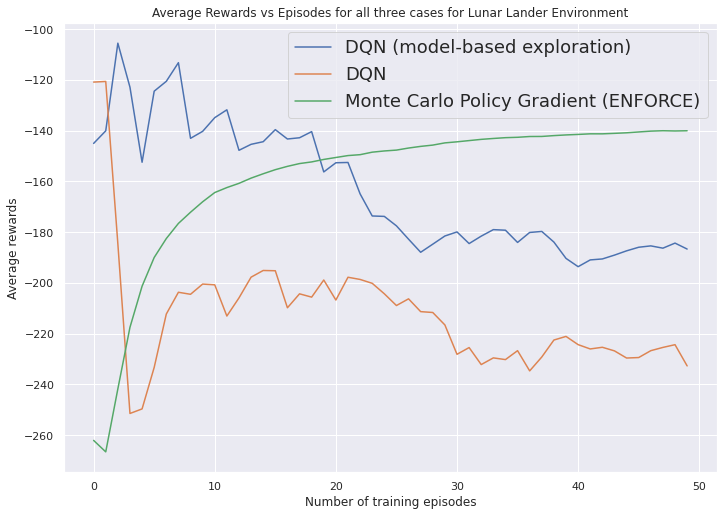

In [37]:
#For Lunar Lander Environment all three cases
ax = sns.lineplot(data=df,color="red", dashes=False)

ax.set_xlabel('Number of training episodes')
ax.set_ylabel('Average rewards')
ax.set_title('Average Rewards vs Episodes for all three cases for Lunar Lander Environment')